<a href="https://colab.research.google.com/github/Matvej911/Matvejs_Aleksejevs_DLBAIPNLP01/blob/main/BERT_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification


#### Load the preprocessed dataset

In [5]:
df = pd.read_csv('dataset_cleaned.csv')


#### Dropping not neccesary columns from the DataFrame

In [6]:
columns_to_drop = ['Message', 'message_len', 'preprocessed_message', 'tokenized_message', 'message_vectors']
df.drop(columns=columns_to_drop, inplace=True)


In [7]:
df.head()

,target,cleaned_message
0,0,yeah probably earlier thatdollar
1,1,cialis viagra xanax valium low price prescript...
2,0,didnt mean post wrote like many times ive ritt...
3,0,hoop try home likely cell clear neal assault p...
4,0,kingwood cove cart green fee wednesday friday ...


#### Custom Dataset Class for Tokenizing and Preparing Email Data for Model Training

In [8]:
class EmailDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        message = str(self.data.cleaned_message[index])
        inputs = self.tokenizer.encode_plus(
            message,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_tensors='pt',
            truncation=True
        )
        return {
            'ids': inputs['input_ids'].flatten(),
            'mask': inputs['attention_mask'].flatten(),
            'targets': torch.tensor(self.data.target[index], dtype=torch.long)
        }

    def __len__(self):
        return len(self.data)


#### Email Classification Training and Evaluation Pipeline Using DistilBERT
This code snippet defines the training and evaluation pipeline for a binary email classification task using the DistilBERT transformer model. It sets up the tokenizer, data loaders, and training and validation functions.

In [9]:
max_len = 64
train_size = 0.8
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
dataset = EmailDataset(df, tokenizer, max_len)

train_data, val_data = random_split(dataset, [int(train_size * len(dataset)), len(dataset) - int(train_size * len(dataset))])
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

# Model Initialization
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
optimizer = AdamW(model.parameters(), lr=1e-5)
model.to('cuda')

train_losses = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1s = []

def train(epoch):
    model.train()
    epoch_losses = []

    for data in train_loader:
        ids = data['ids'].to('cuda')
        mask = data['mask'].to('cuda')
        targets = data['targets'].to('cuda')

        optimizer.zero_grad()
        outputs = model(ids, attention_mask=mask, labels=targets)
        loss = outputs.loss

        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    avg_loss = np.mean(epoch_losses)
    train_losses.append(avg_loss)
    print(f'Epoch {epoch + 1}, Training Loss: {avg_loss:.4f}')

def evaluate():
    model.eval()
    outputs, targets = [], []
    epoch_losses = []

    with torch.no_grad():
        for data in val_loader:
            ids = data['ids'].to('cuda')
            mask = data['mask'].to('cuda')
            target = data['targets'].to('cuda')
            preds = model(ids, attention_mask=mask).logits.argmax(dim=1)
            loss = model(ids, attention_mask=mask, labels=target).loss.item()

            outputs.extend(preds.cpu().numpy())
            targets.extend(target.cpu().numpy())
            epoch_losses.append(loss)

    avg_loss = np.mean(epoch_losses)
    val_losses.append(avg_loss)

    return outputs, targets


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


#### Epoch-based Training and Evaluation Loop for Binary Classification

In [10]:
num_epochs = 10
for epoch in range(num_epochs):
    train(epoch)
    outputs, targets = evaluate()

    accuracy = accuracy_score(targets, outputs)
    precision, recall, f1, _ = precision_recall_fscore_support(targets, outputs, average='binary')

    val_accuracies.append(accuracy)
    val_precisions.append(precision)
    val_recalls.append(recall)
    val_f1s.append(f1)

    print(f'Epoch {epoch + 1}, Validation Loss: {val_losses[-1]:.4f}')
    print(f'Validation Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')


Epoch 1, Training Loss: 0.3745
Epoch 1, Validation Loss: 0.1885
Validation Accuracy: 0.9355
Precision: 0.9429, Recall: 0.9260, F1 Score: 0.9344
Epoch 2, Training Loss: 0.1400
Epoch 2, Validation Loss: 0.1708
Validation Accuracy: 0.9477
Precision: 0.9404, Recall: 0.9552, F1 Score: 0.9477
Epoch 3, Training Loss: 0.0877
Epoch 3, Validation Loss: 0.1597
Validation Accuracy: 0.9544
Precision: 0.9571, Recall: 0.9507, F1 Score: 0.9539
Epoch 4, Training Loss: 0.0524
Epoch 4, Validation Loss: 0.1899
Validation Accuracy: 0.9555
Precision: 0.9531, Recall: 0.9574, F1 Score: 0.9553
Epoch 5, Training Loss: 0.0377
Epoch 5, Validation Loss: 0.1855
Validation Accuracy: 0.9555
Precision: 0.9614, Recall: 0.9484, F1 Score: 0.9549
Epoch 6, Training Loss: 0.0273
Epoch 6, Validation Loss: 0.2113
Validation Accuracy: 0.9555
Precision: 0.9491, Recall: 0.9619, F1 Score: 0.9555
Epoch 7, Training Loss: 0.0164
Epoch 7, Validation Loss: 0.2151
Validation Accuracy: 0.9566
Precision: 0.9615, Recall: 0.9507, F1 Score:

#### Visualization of Training and Validation Metrics over Epochs

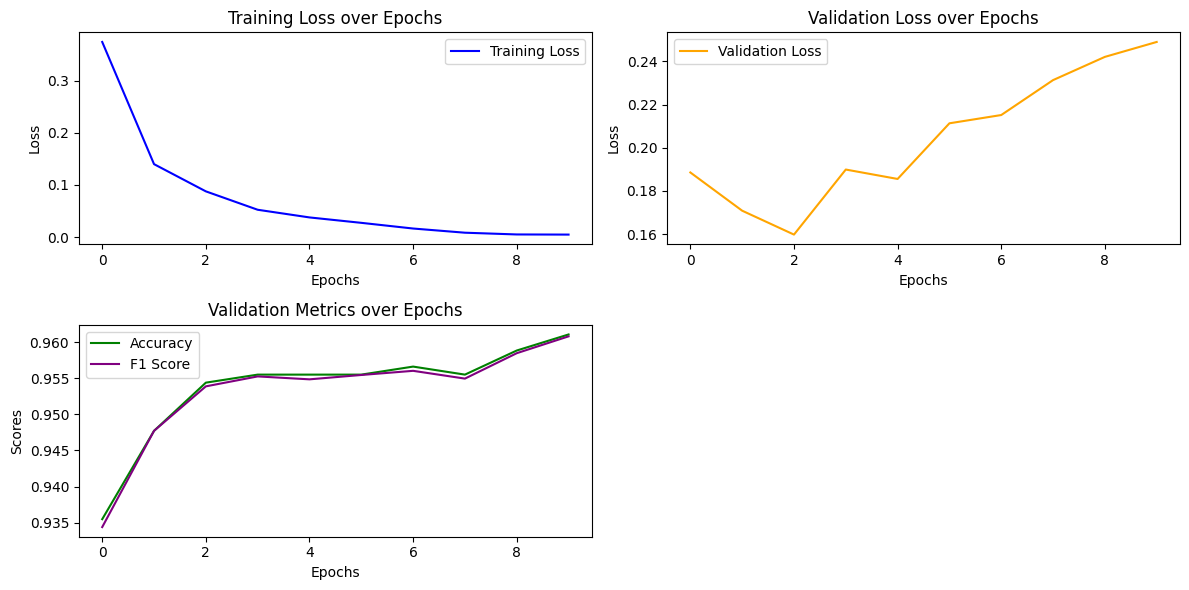

In [11]:
plt.figure(figsize=(12, 6))

# Training Loss
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Validation Loss
plt.subplot(2, 2, 2)
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Validation Metrics
plt.subplot(2, 2, 3)
plt.plot(val_accuracies, label='Accuracy', color='green')
plt.plot(val_f1s, label='F1 Score', color='purple')
plt.title('Validation Metrics over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Scores')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()